In [1]:
import os
import warnings
from pathlib import Path
import numpy as np
import radai
import pickle as pkl
import ipywidgets as widgets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'

warnings.filterwarnings("always", category=radai.data.RadaiDataSetWarning)

# Load a ListmodeH5 dataset

Currently this example set is located in a private drive. Contact the maintainers for access. Units for data sets are:

* milliseconds
* keV
* meters

unless otherwise noted.

In [2]:
DATA = Path(os.environ["RADAI_DATA"])
# h5path = DATA / "Memoryless/source_data_v1.h5"
h5path = DATA / "Memoryless/source_dataset_03112022.h5"
data = radai.data.ListmodeH5(
    h5path, 
    deep_validation=True, 
    energy_bin_edges=radai.tools.sqrt_bins(0, 3000, 64),  # keV 
    time_step_size=500,  # ms
    num_time_bins=100,  # 0.5 s * 100 = 50s
)

## Sources, labels and locations ☢️

In [3]:
data.label_manager.data

name   isotope category  enabled
id                                               
0                 BKG       BKG  unknown     True
1                K-40      K-40  unknown     True
2               Co-57     Co-57  unknown     True
3               Co-60     Co-60  unknown     True
4              Cs-137    Cs-137  unknown     True
5              Ba-133    Ba-133  unknown     True
6        Ir-192_point    Ir-192  unknown     True
7              Ra-226    Ra-226  unknown     True
8              Th-232    Th-232  unknown     True
9              Am-241    Am-241  unknown     True
10               F-18      F-18  unknown     True
11             Tc-99m    Tc-99m  unknown     True
12              I-131     I-131  unknown     True
13             Tl-201    Tl-201  unknown     True
14         NatU-2.5kg      NatU  unknown     True
15          NatU-10kg      NatU  unknown     True
16          NatU-25kg      NatU  unknown     True
17     RefinedU-2.5kg  RefinedU  unknown     True
18      RefinedU-10kg  RefinedU  unknown     True
19      RefinedU-25kg  RefinedU  unknown     True
20          LEU-2.5kg       LEU  unknown     True
21           LEU-10kg       LEU  unknown     True
22           LEU-25kg       LEU  unknown     True
23          HEU-2.5kg       HEU  unknown     True
24           HEU-10kg       HEU  unknown     True
25           HEU-25kg       HEU  unknown     True
26         FGPu-2.5kg      FGPu  unknown     True
27          FGPu-10kg      FGPu  unknown     True
28          FGPu-25kg      FGPu  unknown     True
29         WGPu-2.5kg      WGPu  unknown     True
30          WGPu-10kg      WGPu  unknown     True
31          WGPu-25kg      WGPu  unknown     True
32              Cu-67     Cu-67  unknown     True
33              Sr-90     Sr-90  unknown     True
34  Ir-192_industrial    Ir-192  unknown     True

## Set the label tier (grouping)

Here we group the raw source names from above into tier 1 groups which are sources of the same composition with different shielding configurations. We also disable some sources.

In [4]:
data.label_manager.tier = 1
data.label_manager.disable_items(
    "LEU", "HEU", "WGPu", "FGPu", "NatU", "RefinedU", 
    "K-40", "Ra-226", "Th-232", "Tl-201"
)
print("The active labels are:")
print(data.label_manager.get_labels_list())
print("The active label map:")
print(data.label_manager.labels_num2str_map)


The active labels are:
['BKG', 'Co-57', 'Co-60', 'Cs-137', 'Ba-133', 'Ir-192', 'Am-241', 'F-18', 'Tc-99m', 'I-131', 'Cu-67', 'Sr-90']
The active label map:
{0: 'BKG', 1: 'Co-57', 2: 'Co-60', 3: 'Cs-137', 4: 'Ba-133', 5: 'Ir-192', 6: 'Am-241', 7: 'F-18', 8: 'Tc-99m', 9: 'I-131', 10: 'Cu-67', 11: 'Sr-90'}


# Get a summed spectrum per label

These will be used later as source templates

In [5]:
templates = data.get_sum_spectrum_per_label(progress_bar=True)

Calc spectra per run:   0%|          | 0/66 [00:00<?, ?it/s]

/home/jccurtis/workspaces/radai_stack/submodules/radai/radai/data/listmode_h5/data_set.py:611: RadaiDataSetWarning: Not including the following disabled sources in the source locations for run 1: [13]
  warn(
/home/jccurtis/workspaces/radai_stack/submodules/radai/radai/data/listmode_h5/data_set.py:611: RadaiDataSetWarning: Not including the following disabled sources in the source locations for run 4: [24 25 26 27 28]
  warn(
/home/jccurtis/workspaces/radai_stack/submodules/radai/radai/data/listmode_h5/data_set.py:611: RadaiDataSetWarning: Not including the following disabled sources in the source locations for run 6: [1]
  warn(
/home/jccurtis/workspaces/radai_stack/submodules/radai/radai/data/listmode_h5/data_set.py:611: RadaiDataSetWarning: Not including the following disabled sources in the source locations for run 11: [1]
  warn(
/home/jccurtis/workspaces/radai_stack/submodules/radai/radai/data/listmode_h5/data_set.py:611: RadaiDataSetWarning: Not including the following disabled 

## Setup SNR Labeler and Data Augmentor

Note that `'RefinedU', 'LEU'` have low SNR in this dataset and are therefore previously turned off (along with some others) for this demo. Future datasets will have larger SNR for all sources such that they can be downsampled while still remaining within an SNR regime above threshold.

In [8]:
data.set_labeler("snr", threshold=5.0)
data.augmentor.binomial_downsample(p_source=[0.95])
data.augmentor.reverse_time(0.5)

# Make training data (pickled for future use)

In [11]:
train_batch_backup = Path('./ListmodeH5-Train-Batch.pkl')
if train_batch_backup.is_file():
    with train_batch_backup.open("rb") as infile:
        train_batch = pkl.load(infile)
else:
    data.augmentor.set_seed(42)
    train_batch = data.generate_data("spectrum_batch", 500*data.label_manager.num_labels)
    with train_batch_backup.open("wb") as infile:
        pkl.dump(train_batch, infile)

## Number of items per label

In [12]:
train_batch.labels.booleans_dataframe.sum()

label
BKG       500
Co-57     500
Co-60     500
Cs-137    500
Ba-133    500
Ir-192    500
Am-241    500
F-18      500
Tc-99m    500
I-131     500
Cu-67     500
Sr-90     500
dtype: int64

## Make variables to refer to training arrays

In [14]:
train_labels = train_batch.labels.single_encounter_label_nums
train_spectra = train_batch.spectra_2d
print(np.unique(train_labels))
print(train_spectra.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
(6000, 64)


## Plot sum spectra for each label in the training set

In [15]:
sum_spectra = np.vstack([
    train_spectra[train_labels == i].sum(axis=0) 
    for i in data.label_manager.labels_num2str_map.keys()
])
print(sum_spectra.shape)

def plot_label(label):
    fig, ax = plt.subplots(1, figsize=(10, 4))
    spec = sum_spectra[data.label_manager.labels_str2num(label)]
    x, y = radai.tools.hist_outline([spec, data.energy_bin_edges])
    ax.plot(x, y)
    ax.set_title(label)
    
widgets.interact(plot_label, label=data.label_manager.get_labels_list());

(12, 64)


interactive(children=(Dropdown(description='label', options=('BKG', 'Co-57', 'Co-60', 'Cs-137', 'Ba-133', 'Ir-…

# Create a multi-source censored-energy-window algorithm (MCEW) and train it

_Note: the time unit in Algorithms is `seconds`._

There are currently three ways to train a `MCEW` algorithm:
* Known source templates
* NMF derived source templates
* A genetic algorithm (from the [`deap` package](https://deap.readthedocs.io/en/master/index.html)) is used to find the optimal spectral bins with a data-driven approach to optimize SNR. Caveats:
    * There are many configuration params for the genetic algo training, we will use the defaults except the number of generations to evaluate.
    * Each source is trained independently.
    * **CURRENTLY** the sources are trained sequentially. Parallelization of this has been unsuccessfully attempted using tools in the `deap` pacakge itself. That said, the numpy routines used within are parallelized for some distributed binaries (i.e. with `conda` on macOS with an Intel processor).

In [17]:
FIT_MODE = "KNOWN"
# FIT_MODE = "NMF"
# FIT_MODE = "GENETIC"

alg = radai.algorithms.MultiplexedCEW(int_time=data.time_step_size/1e3)

if FIT_MODE == "KNOWN":
    # Known source templates
    train_info = alg.fit_known_sources(
        train_spectra,
        train_labels,
        templates.values[1:, :],
        data.label_manager.labels_str2num(templates.index.values[1:]),
    )
elif FIT_MODE == "NMF":
    # Derive NMF templates
    train_info = alg.fit_nmf(
        train_spectra,
        train_labels,
        src_ids=None,
        verbose=False,
        alpha=10.0,
        sparsity=1e-5,
        fit_intercept=True,
    )
elif FIT_MODE == "GENETIC":
    # Genetic algorithm training detailed training (takes some time)
    train_info = alg.fit(
        train_spectra, 
        train_labels, 
        src_ids=None, 
        ngen=50,
        verbose=True,
    )

## The algorithm contains a sub algorithm for each training label

In [18]:
alg.sub_alg

{1: <radai.algorithms.cew.CEW at 0x7f1aacfd6580>,
 2: <radai.algorithms.cew.CEW at 0x7f1ab4289ac0>,
 3: <radai.algorithms.cew.CEW at 0x7f1aad2c14c0>,
 4: <radai.algorithms.cew.CEW at 0x7f1aad3948b0>,
 5: <radai.algorithms.cew.CEW at 0x7f1ab45f6070>,
 6: <radai.algorithms.cew.CEW at 0x7f1aad2c1d30>,
 7: <radai.algorithms.cew.CEW at 0x7f1aad2b05e0>,
 8: <radai.algorithms.cew.CEW at 0x7f1ab4dc4be0>,
 9: <radai.algorithms.cew.CEW at 0x7f1ab4281760>,
 10: <radai.algorithms.cew.CEW at 0x7f1aad2c1340>,
 11: <radai.algorithms.cew.CEW at 0x7f1aad13fb20>}

## Visualize the templates and weights

In [19]:
if FIT_MODE == "NMF":
    from becquerel import SpectrumPlotter
    steps = SpectrumPlotter.bin_edges_and_heights_to_steps
    fig, axes = plt.subplots(4, 6, sharex=True, figsize=(14, 8), facecolor='white')
    even_rows = np.arange(0, axes.shape[0], 2)
    odd_rows = np.arange(1, axes.shape[0], 2)
    for i in range(1, data.label_manager.num_labels):
        ax = axes[even_rows, :].flatten()[i-1] 
        ax.plot(*steps(data.energy_bin_edges, train_info[i]['src_spectrum']), c='crimson', label='Source')
        ax.plot(*steps(data.energy_bin_edges, train_info[i]['bkg_spectrum']), c='grey', label='Background')
        ax.set_yscale('symlog', linthresh=1e-2)
        ax.set_title(data.label_manager.labels_num2str(i))
    #     if i == 1:
    #         ax.legend()
        # Plot weights
        ax = axes[odd_rows, :].flatten()[i-1]
        ax.plot(*steps(data.energy_bin_edges, alg.sub_alg[i].w_s), c='crimson', label='Source')
        ax.plot(*steps(data.energy_bin_edges, alg.sub_alg[i].w_b), c='grey', label='Background')
    #     if i == 1:
    #         ax.legend()
    for ax in axes[-1, :]: ax.set_xlabel('Energy')
    for ax in axes[even_rows, 0]: ax.set_ylabel('Template')
    for ax in axes[odd_rows, 0]: ax.set_ylabel('Weights')
    axes.flatten()[0].legend();
    plt.tight_layout();

## CEW alarm threshold

The per source classification metric for CEW is the `negative-log-survival`. 
The threshold was automatically set in the init using the default FAR (1/8hr).
In this case the threshold is determined from the `far` and `int_time`.
Generalized empirical (data-driven) threshold calculation is under development.

Below we change the threshold using a FAR of 1/hr.

TODO: Add this threshold setting to the multiplex base class.

In [20]:
print("Defaults:")
print(f'FAR: {alg.sub_alg[1].far}')
print(f'threshold: {alg.sub_alg[1].threshold}')
for _alg in alg.sub_alg.values():
    _alg.far = 1.
    _alg.calculate_threshold(set_threshold=True)
print("New:")
print(f'FAR: {alg.sub_alg[1].far}')
print(f'threshold: {alg.sub_alg[1].threshold}')

Defaults:
FAR: 0.125
threshold: 10.961277846683982
New:
FAR: 1.0
threshold: 8.881836305004146


## Save it

In [21]:
filename = 'mcew_nmf.yaml'
alg.write(filename)
!head $filename

/usr/bin/zsh: /home/jccurtis/miniconda3/envs/radai/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
__class__: radai.algorithms.multiplexed_cew.MultiplexedCEW
alg1:
  far: 1.0
  int_time: 0.5
  intercept: 31.313699469305448
  w_b:
  - -30.14258495861835
  - -3.2420156504326125
  - 21.536919903138056
  - 0.0


## There are two ways to read this algorithm

Both are included for demonstration:

In [22]:
print(radai.algorithms.MultiplexedCEW.read(filename))
print(radai.io.read(filename))

# Test data

In [23]:
test_batch_backup = Path('./ListmodeH5-Test-Batch.pkl')
if test_batch_backup.is_file():
    with test_batch_backup.open("rb") as infile:
        test_batch = pkl.load(infile)
else:
    data.augmentor.set_seed(123456789)
    test_batch = data.generate_data("spectrum_batch", 100*data.label_manager.num_labels)
    with test_batch_backup.open("wb") as infile:
        pkl.dump(test_batch, infile)
        
test_labels = test_batch.labels.single_encounter_label_nums
test_spectra = test_batch.spectra_2d
print(np.unique(test_labels))
print(test_spectra.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
(1200, 64)


## Test it

NOTE: The second argument is for timestamps which are not used for this algorithm. 
In general, the timestamp is used because the input data is streaming during deployment.

In [24]:
results_batch = alg.analyze_batch(test_spectra, np.zeros((len(test_spectra))), )

## Get performance Metrics

In [26]:
# Ground truth
test_true = test_labels

# The results are verbose. We just need the detected source id's.
test_pred = []
metrics_pred = []
for results in results_batch:
    # For the results in each analysis get the booleans and scalars
    alarms = results.get_all('is_alarm')
    alarm_metrics = results.get_all('alarm_metric')
    metrics_pred.append(alarm_metrics)
    if sum(alarms) == 0:
        # No alarm
        test_pred.append(0)
    elif sum(alarms) == 1:
        # One alarm
        test_pred.append(np.nonzero(alarms)[0][0] + 1)
    else:
        # Get the highest alarm
        test_pred.append(np.argmax(alarm_metrics) + 1)
test_pred = np.asarray(test_pred)
metrics_pred = np.vstack(metrics_pred)
test_pred.shape

(1200,)

## Look at metrics colored by the groundtruth

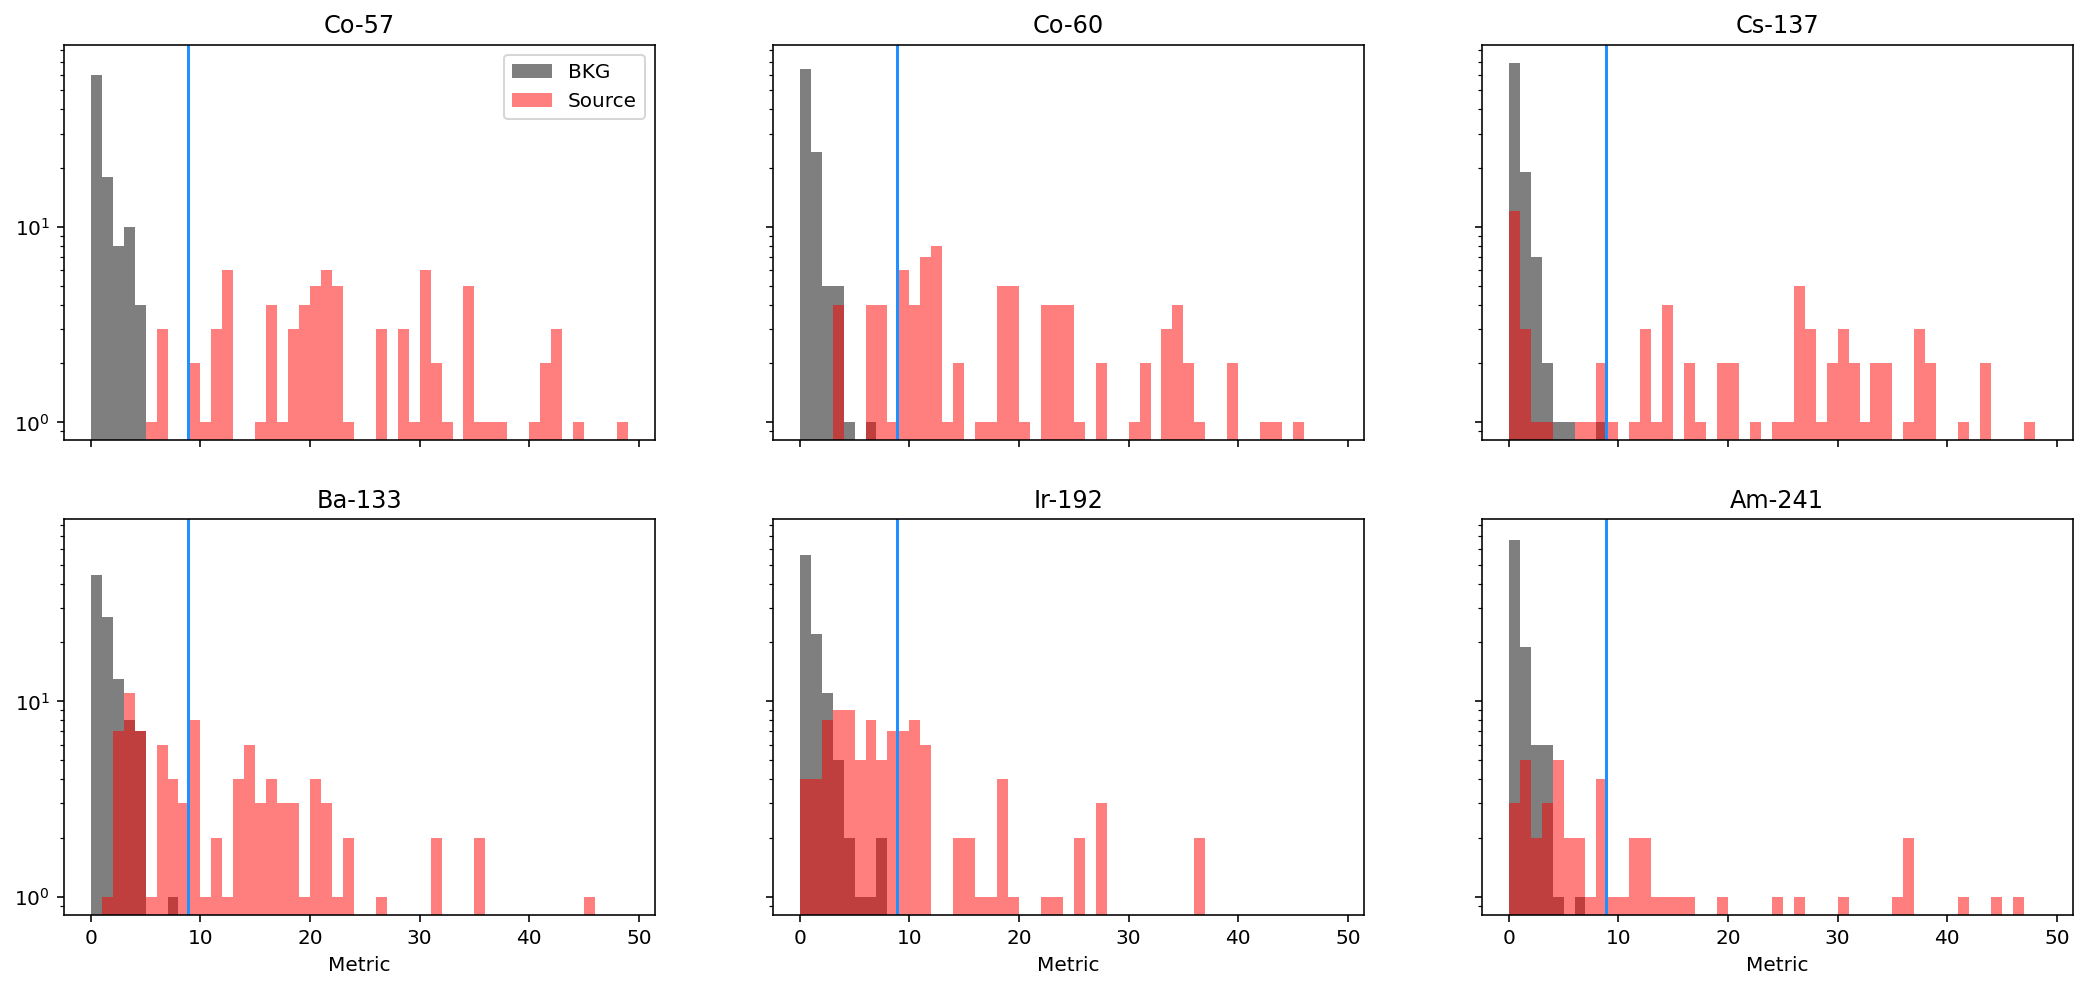

In [59]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(18, 8))
bins = np.arange(0, 50, 1)
# bins = 50
for idx in range(1, 7):
    ax = axes.flatten()[idx-1]
    ax.hist(metrics_pred[test_true==0, idx-1], bins=bins, alpha=0.5, color='k', label='BKG');
    ax.hist(metrics_pred[test_true==idx, idx-1], bins=bins, alpha=0.5, color='r', label='Source');
    ax.semilogy()
    ax.set_title(data.label_manager.labels_num2str(idx))
    ax.axvline(alg.sub_alg[idx].threshold, color="dodgerblue")
for ax in axes[-1, :]: ax.set_xlabel('Metric')
axes.flatten()[0].legend();

## Look at the metrics vs SNR

In [67]:
y_max = 100

fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(14, 8), facecolor='white')
even_rows = np.arange(0, axes.shape[0], 2)
odd_rows = np.arange(1, axes.shape[0], 2)
for i, label in enumerate(data.label_manager.get_labels_list()[1:]):
    ax = axes.flatten()[i]
    idx = data.label_manager.labels_str2num(label)
    # Mask using the source ground-truth
    msk = test_true == idx
    x = test_batch.labels.scalars_dataframe[label].values[msk]
    y = np.clip(metrics_pred[msk, i], a_min=None, a_max=y_max)
    thresh = alg.sub_alg[idx].threshold
    # Mask of the metrics above threshold
    alarm_msk = y>=thresh
    ax.scatter(x[alarm_msk], y[alarm_msk], color="red")
    ax.scatter(x[~alarm_msk], y[~alarm_msk], color="grey")
    ax.set_title(label)
    # ax.semilogy()
    ax.set_ylim(0, y_max)
    ax.text(
        0.8, 0.9, f"TPR: {np.sum(alarm_msk)/len(y)}", color="red",
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes
    )
    ax.text(
        0.8, 0.8, f"FNR: {np.sum(~alarm_msk)/len(y)}", color="grey",
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes
    )
    ax.axhline(thresh, color="red")
for ax in axes[-1, :]: ax.set_xlabel('SNR')
for ax in axes[:, 0]: ax.set_ylabel('Alarm Metric (Clipped)')
plt.tight_layout();

## Confusion Matrices

Display all metrics organized by true and predicted labels

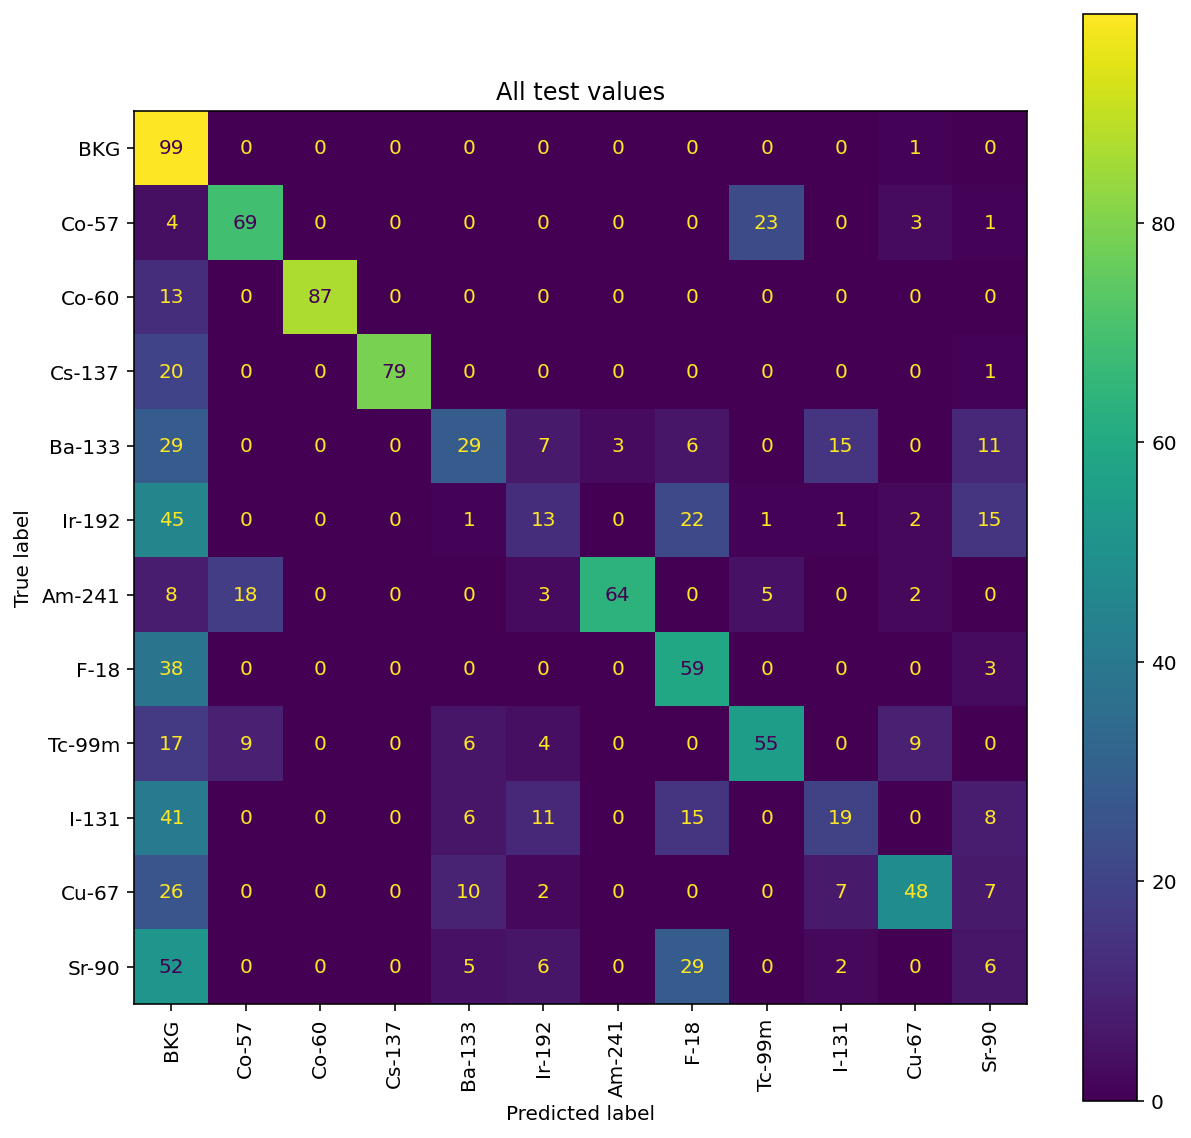

In [44]:
cm = confusion_matrix(test_true, test_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=data.label_manager.get_labels_list(),
)
sns.reset_orig()
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('All test values')
disp.plot(ax=ax);
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90);

# filter background to add contrast to plot
test_msk = ~((test_true == 0) & (test_pred == 0))
cm = confusion_matrix(test_true[test_msk], test_pred[test_msk])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=data.label_manager.get_labels_list()
)
sns.reset_orig()
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Test values without True Positive Background')
disp.plot(ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 90);

## Notes on the confusion matrix

* The most notable feature is the high false-negative rate on a per spectrum basis. These are likely the low SNR spectra in the tails of the encounters.
* Some of the training spectra are low peak SNR which the current SNR labeling does not account for. This leads to the large windows for some of the sources show in the weight plots above.
* Several sources (particularly those of low energy `<300keV`) exhibit significant cross-talk due to the non-specific windows determined during training:
    * Co57, Am241
    * I131, B133
    * Am241, Th201
* This means the CEW training uses quite a few low SNR source spectra.
* There are very few source spectra to test with (almost all background). 
* Of those many are low SNR.